In [18]:
import tensorflow as tf
import numpy as np
from tensorflow.python.ops import math_ops
import matplotlib.pyplot as plt
import time
import Utils.midi_musical_matrix
import Utils.data
import Utils.multi_training
from tensorflow.contrib.rnn import BasicLSTMCell
from tensorflow.contrib.rnn import LSTMStateTuple
from MyFunctions import Input_Kernel, LSTM_TimeWise_Training_Layer, LSTM_NoteWise_Layer, Loss_Function

# Plot configurations
% matplotlib inline
# Notebook auto reloads code. (Ref: http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython)
% load_ext autoreload
% autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [23]:
# Import All Training Data
# Convert Entire Music .MIDI set to list of 'pieces'
# During training runs, getPieceBatch will return a tensor for Note_State_Batch, and corresponding Note_State_Expand
# Note_State_Expand will be fed into the graph input, and Note_State_Batch will be used for the loss function.


Training_Midi_Folder = "C:/Users/Paul/Neural_Networks/Project/Generating_Music/Midi_Files/Bach"

training_pieces = Utils.multi_training.loadPieces(Training_Midi_Folder)

print('')
print('Number of training pieces = ', len(training_pieces))
sample_expand, sample_state = Utils.multi_training.getPieceBatch(training_pieces)
sample_expand, sample_state = np.array(x_expand), np.array(x_state)

sample_expand = np.swapaxes(sample_expand, axis1=1, axis2=2)
sample_state = np.swapaxes(sample_state, axis1=1, axis2=2)

print('Sample of Expanded Input Batch: shape = ', sample_expand.shape)
print('Sample of State Input Batch: shape = ', sample_state.shape)


Loaded 01Allemande
Loaded 01Prelude
Loaded 02Ichdankdir
Loaded 03AchGott
Loaded 04Allemande
Loaded 04Bourree
Loaded 04EsistdasHeiluns
Loaded 04Prelude
Loaded 05AnWasserflussen
Loaded 06Christus
Loaded 08Freueteuch
Loaded 09Ermuntredich
Loaded 10AustieferNot
Loaded 11Jesu
Loaded 13Alleinzudir
Loaded 14OHerreGott
Loaded 15ChristlaginTode
Loaded BRAND1
Loaded BRAND3
Loaded BRAND43
Loaded BRAND51
Loaded BRAND52
Loaded BRAND53
Loaded BSGJG_A
Loaded BSGJG_B
Loaded BSGJG_C
Loaded BSGJG_D
Loaded BSGJG_E
Loaded BSGJG_F
Loaded BSGJG_G
Loaded BSGJG_H
Loaded BSGJG_I
Loaded BSGJG_J
Loaded BSGJG_K
Loaded BSGJG_L
Loaded can4
Loaded cap2
Loaded catech1
Loaded catech10
Loaded catech11
Loaded catech2
Loaded catech3
Loaded catech4
Loaded catech5
Loaded catech6
Loaded catech7
Loaded catech8
Loaded catech9
Loaded catechor
Loaded cnt1 (1)
Loaded cnt1
Loaded cnt2
Loaded cnt3
Loaded dou1
Loaded dou2
Loaded Fugue1 (1)
Loaded Fugue1
Skip bad file =  Fugue11
Loaded Fugue12 (1)
Skip bad file =  Fugue12
Skip bad f

In [24]:
# Beginning of Model Graph:
tf.reset_default_graph()

input_size = sample_expand.shape[-1]
num_notes = sample_expand.shape[1]


#place holder inputs
# num_batches and num_time steps are variable lengths.  These values do not affect the model parameters
# Dimension(0) =  num_batches. Dimension(2) = num_time_steps
Note_State_Batch = tf.placeholder(dtype=tf.float32, shape=[None, num_notes, None, 2])
Note_State_Expand = tf.placeholder(dtype=tf.float32, shape=[None, num_notes, None, input_size])
prev_t_sample = tf.placeholder(dtype=tf.float32, shape=[None, num_notes,1])

#Generates expanded tensor input to LSTM-timewise layer
#Note_State_Expand, final_t_sample = Input_Kernel(Note_State_Batch, prev_t_sample)

print('Note_State_Expand Placeholder Shape = ', Note_State_Batch.get_shape())
print('Note_State_Expand Placeholder Shape = ', Note_State_Expand.get_shape())


Note_State_Expand Placeholder Shape =  (?, 78, ?, 2)
Note_State_Expand Placeholder Shape =  (?, 78, ?, 80)


In [25]:
#lSTM Time Wise Training Graph 
num_units=50
timewise_c=tf.placeholder(dtype=tf.float32, shape=[None, num_notes, num_units])
timewise_h=tf.placeholder(dtype=tf.float32, shape=[None, num_notes, num_units])
timewise_state_in = LSTMStateTuple(timewise_h, timewise_c)

#Note_State_Expand = tf.placeholder(dtype=tf.float32, shape=[None, num_notes, None, input_size])
timewise_out, timewise_state = LSTM_TimeWise_Training_Layer(input_data=Note_State_Expand, state_in=timewise_state_in)




print('Time-wise output shape = ', timewise_out.get_shape())
print('Time-wise state  = ', timewise_state[0])
print('Time-wise state  = ', timewise_state[1])

Time-wise output shape =  (?, 78, ?, 50)
Time-wise state  =  Tensor("Reshape_5:0", shape=(?, 78, 50), dtype=float32)
Time-wise state  =  Tensor("Reshape_4:0", shape=(?, 78, 50), dtype=float32)


In [26]:
#LSTM Note Wise Graph

logP_out, pa_gen_out = LSTM_NoteWise_Layer(timewise_out)


print('logP out shape = ', logP_out.get_shape())
print('generated samples shape = ', pa_gen_out.get_shape())




logP out shape =  (?, 78, ?, 3)
generated samples shape =  (?, 78, ?, 1)


In [8]:
# Loss Function and Optimizer


loss = Loss_Function(Note_State_Batch, logP_out)

optimizer = tf.train.GradientDescentOptimizer(learning_rate = .1).minimize(loss)



In [10]:
# Training
N_epochs = 10
loss_hist=[]
restore_model_name = 'Trained Model'
save_model_name = 'Trained Model'
batch_size = 10
num_timesteps = 96

with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    saver = tf.train.Saver()
    # try to restore the pre_trained
    if restore_model_name is not None:
        print("Load the model from: {}".format(restore_model_name))
        saver.restore(sess, 'model/{}'.format(restore_model_name))
    
    c_run = np.zeros((batch_size, num_notes, num_units))
    h_run = np.zeros((batch_size, num_notes, num_units))
    first_input_load = np.zeros((batch_size, num_notes, 1)) #start every sequence with zero previous input

    for epoch in range(N_epochs):
        
        #Generate Note_State Batch numpy tensor (bogus data for now)
        batch_input = np.random.randint(low=0, high=1, size=[batch_size, num_notes, num_timesteps]).astype(np.float32) 
        feed_dict = {Note_State_Batch: batch_input, timewise_c: c_run, timewise_h: h_run, prev_t_sample: first_input_load}
        final_t_sample_run, state_run, loss_run, _ = sess.run([final_t_sample, timewise_state, loss, optimizer], feed_dict=feed_dict)
        c_run, h_run = state_run
        
        
        print('epoch = ', epoch, '; loss = ', loss_run)
        loss_hist.append(loss_run)
        
    save_path = saver.save(sess, 'model/{}'.format(save_model_name))
    print("Model saved in file: %s" % save_path)


Load the model from: Trained Model
INFO:tensorflow:Restoring parameters from model/Trained Model
epoch =  0 ; loss =  0.322415
epoch =  1 ; loss =  0.310493
epoch =  2 ; loss =  0.304235
epoch =  3 ; loss =  0.300668
epoch =  4 ; loss =  0.298011
epoch =  5 ; loss =  0.29576
epoch =  6 ; loss =  0.293727
epoch =  7 ; loss =  0.291853
epoch =  8 ; loss =  0.290116
epoch =  9 ; loss =  0.28849
Model saved in file: model/Trained Model


In [11]:
for v in range(len(tf.trainable_variables())):
    print(tf.trainable_variables()[v])

<tf.Variable 'rnn/basic_lstm_cell/kernel:0' shape=(105, 200) dtype=float32_ref>
<tf.Variable 'rnn/basic_lstm_cell/bias:0' shape=(200,) dtype=float32_ref>
<tf.Variable 'basic_lstm_cell/kernel:0' shape=(54, 12) dtype=float32_ref>
<tf.Variable 'basic_lstm_cell/bias:0' shape=(12,) dtype=float32_ref>


10

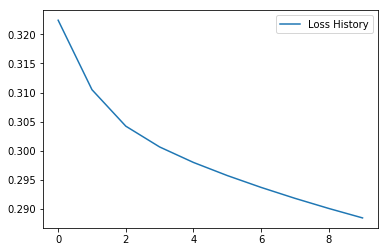

In [12]:
plt.plot(loss_hist, label="Loss History")
plt.legend()
plt.show
len(loss_hist)

In [13]:
# Music Generation
# input = initial note vector
# for t = 1:Tsong
#    input --> input kernel
#    run through 1 'call' of Model LSTM with present parameters / states
#    run through note-wise LSTM block as normally done to produce vector of generated samples
#    input = generated samples
#    music_sequence.append(input)

# store batch of music sequences in .MIDI files


#Load Model
restore_model_name = 'Trained Model'

#Length of generated music
T_gen = 48*16
batch_gen_size = 10


# start with initial Note_State_Batch with 't' dimension = 1 (can still a batch of samples run in parallel)
notes_gen_initial = np.zeros((batch_gen_size, num_notes, 1))
notes_gen = notes_gen_initial
c_run = np.zeros((batch_gen_size, num_notes, num_units))
h_run = np.zeros((batch_gen_size, num_notes, num_units))   
notes_gen_arr=[]
latest_input = np.zeros((batch_size, num_notes, 1))
with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    saver = tf.train.Saver()
    
    print("Load the model from: {}".format(restore_model_name))
    saver.restore(sess, 'model/{}'.format(restore_model_name))
    

    for t in range(T_gen):
        feed_dict = {Note_State_Batch: notes_gen,timewise_c: c_run, timewise_h: h_run, prev_t_sample: latest_input}
        final_t_sample_run, state_run, notes_gen = np.squeeze(sess.run([final_t_sample, timewise_state, pa_gen_out], feed_dict = feed_dict), axis=2)
        c_run, h_run = state_run
        notes_gen = np.squeeze(notes_gen, axis=2)
        notes_gen_arr.append(np.squeeze(notes_gen))
        latest_input = final_t_sample_run
        
        if t % 50 == 0:
            print('Timestep = ', t)
    
notes_gen_out = np.stack(notes_gen_arr, axis=2)
print(notes_gen_out.shape)
        


Load the model from: Trained Model
INFO:tensorflow:Restoring parameters from model/Trained Model
Timestep =  0
Timestep =  50
Timestep =  100
Timestep =  150
Timestep =  200
Timestep =  250
Timestep =  300
Timestep =  350
Timestep =  400
Timestep =  450
Timestep =  500
Timestep =  550
Timestep =  600
Timestep =  650
Timestep =  700
Timestep =  750
(10, 79, 768)


Items to Experiment with:
- different T length or variable length T from batch-to-batch for training
- categorize music, either through (unsupervised) clustering or (supervised) labeled music folders.  For clustering, the model would possibly find 'k' 'centroids' in an unsupervised manner each with its own music distribution, so during the music generation stage, 1 of these centroids would be selected for a piece of music.  
- use encoder to reduce dimensionality of each note vector (vector of 79 notes in 1 time step), similiar to encoding the words from the tweets in homework 3 (i.e. there are restricted combinations of notes that can be played simultaneously)
- more advanced sampling/exploring for training/music generation.  This may help prevent the algorithm from getting 'stuck' on a chord, or 